In [1]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier

# We need to import some Sci-kit Learn modules for computation purposes.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Global Settings - These settings are critical

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)


/home/jaren/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Import the data
'''
# select the root = ....

mnist = torchvision.datasets.MNIST(root = './data', 
                                   train = True, 
                                   transform = transforms.ToTensor(),  
                                   download = True)

test_dataset = torchvision.datasets.MNIST(root = './data', 
                                          train = False, 
                                          transform = transforms.ToTensor())


X_train = mnist.data
y_train = mnist.targets

X_test = test_dataset.data
y_test = test_dataset.targets


'''
Step -- Normalize each input from [0.0,1.0] range
'''

X_train = X_train / 255.0
X_test = X_test / 255.0

'''
Step -- Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)



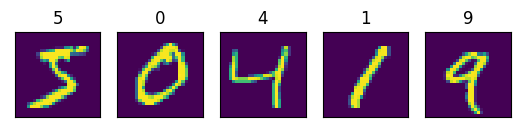

In [3]:

'''
Will do some basic plotting to get a feel for the data that we imported.

'''

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())
        
plot_example(X_train, y_train)

In [4]:
# build your CNN 
class CNN(nn.Module):
    def __init__(self, dropout = 0.4, batch_normalization = False):
        super().__init__()
        '''Step -- Fill in the architecture'''

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size = 5, padding=2),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.BatchNorm2d(32) if batch_normalization else nn.Identity()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 5, padding=2),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64) if batch_normalization else nn.Identity()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(64*7*7, 256), 
            nn.ReLU(), 
            nn.BatchNorm1d(256) if batch_normalization else nn.Identity()
        )

        self.dropout = nn.Dropout(dropout)

        self.fc2 = nn.Sequential(
            nn.Linear(256, 10), 
            nn.ReLU()
        )

        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''

        output = self.conv1(x)
        output = self.conv2(output)

        output = output.reshape(output.size(0), -1)
        output = self.fc1(output)

        output = self.dropout(output)

        output = self.fc2(output)
    
        return self.softmax(output)

In [5]:
# Adding L1 regularization

class RegularizedNet(NeuralNetClassifier):
    
    ''''''
    
    def __init__(self, *args, lambda1 = 0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1
    
    ''' *** Explain -- What is the following method doing? Explain in detail in the main pdf ***'''
    
    def get_loss(self, y_pred, y_true, X = None, training = False):
        loss = super().get_loss(y_pred, y_true, X = X, training = training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

In [6]:
# print out the structure of the model 
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Identity()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Identity()
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Identity()
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): ReLU()
  )
  (softmax): Softmax(dim=1)
)


In [7]:
'''
Here we define the RegularizedNet. Make sure you use nn.NLLLoss. Thus, you have to use a correct last activation
in the forward method of your network

We can specify different parameters such as learning rate (lr), our optimizar (start with standard SGD, in 4.3 we will
try another ones), batch size etc.
To define the arquitecture parameters for CNN write them as module__<name of your parameter> = ....

Since we have to train it first with L2 regularization lambda1 should be equal to 0
'''
cnn = RegularizedNet(
    module = CNN, 
    max_epochs = 10,
    criterion = torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD,
    lr = 0.1, 
    lambda1 = 0,
    module__dropout = 0.5,
    optimizer__weight_decay = 0,
    batch_size = 64,
    device = device
)
    

In [8]:
'''Step - train the network'''

cnn.fit(X_train, y_train)
y_pred_probs = cnn.predict(X_test)

'''
Look how your loss is going down as well as the validation accuracy is increasing 
'''

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3512       0.9682        0.1000  8.1751
      2        0.0913       0.9768        0.0776  2.3419


'\nLook how your loss is going down as well as the validation accuracy is increasing \n'

In [ ]:
'''Step - Predict for the test set and print the final accuracy score, your validation accuracy obtained in the previous
cell should be similar to the accuracy in the test set
'''
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
'''The idea is that you should get more than 98% of accuracy, so try different parameters as requested in the main pdf
The fit method is already showing you a validation error which can be used to compare between different parameters.

for the final submission leave the best parameters in your RegularizedNet(...)
'''
'''
Instead of doing it manually skorch allows us to use GridSearchCV from sklearn 
'''
from sklearn.model_selection import GridSearchCV

'''
Step - define a grid with some parameters that you consider may give you good results and 
the code will do the rest for you

* Especially take into account the parameters we are asking for to tune:  
Learning rate, regularization parameter, and the number of nodes

'''
# you can use cnn.get_params().keys() to get all the parameters that you can tune

grid = {
    'lr': [0.1, 0.15, 0.2],
    'optimizer__weight_decay': [0, 0.01, 0.1],
    'module__dropout': [0.4, .3, .5],
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn, grid, refit = True, cv = 5, scoring = 'accuracy', verbose=4)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)


In [ ]:
'''
Step - Now we are going to train the network with L1 regularization instead of L2 and dropout,
we are going to create a new network with a lambda1 parameter different than 0
- Keep the rest of the parameters you used in the previous network but dropout and L2 parameters are 0 
'''

cnn_l1 = RegularizedNet(
    module = CNN, 
    max_epochs = 10,
    criterion = torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD,
    lr = 0.1, 
    lambda1 = 0,
    module__dropout = 0.5,
    optimizer__weight_decay = 0,
    batch_size = 64,
    device = device
)

In [ ]:
#Refer to https://skorch.readthedocs.io/en/stable/user/save_load.html

import pickle

#Transfer Learning - 
#The following code will transfer the weights from L2 trained networks to initialize the new network before L1 training

'''

Notes - I assumed you have trained your L2 network using Skorch's NeuralNetClassifier
        I assume your trained model object is called "cnn"

'''

#Step - 1 - Save weights from L2 network

cnn.save_params(f_params='some-file.pkl') # This comes after cnn.fit(). You are saving the model weights in a pickle


#Step - 2

cnn_l1.initialize()
cnn_l1.load_params(f_params='some-file.pkl')



In [ ]:
'''
Step train the network with the weights transfered from cnn, and perform grid search for the lambda1 parameter
'''

grid = {
    'lambda1': [0, 0.01, 0.001]
}


gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 5, scoring = 'accuracy', verbose=4)
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)

In [9]:
'''
Step train the network with default initialization parameters
we can simply initialize with the same code as before (make sure to use the same parameters)

perform grid search for the lambda1 parameter as in the previous cell
'''

cnn_l1 = RegularizedNet(
    module = CNN, 
    max_epochs = 10,
    criterion = torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD,
    lr = 0.1, 
    lambda1 = 0,
    module__dropout = 0.5,
    optimizer__weight_decay = 0,
    batch_size = 64,
    device = device
)

grid = {
    'lambda1': [0, 0.01, 0.001]
}


gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 5, scoring = 'accuracy', verbose=4)
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)




Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4320       0.9692        0.0963  1.9265
      2        0.0972       0.9757        0.0747  1.8592
[CV 1/5] END .........................lambda1=0;, score=0.981 total time=   4.2s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4810       0.9576        0.1298  1.9078
      2        0.1051       0.9707        0.0953  1.9053
      3        0.0770       0.9816        0.0619  1.8591
      4        0.0610       0.9821        0.0625  1.8630
      5        0.0503       0.9834        0.0583  1.8597
      6        0.0444       0.9870        0.0472  1.9074
      7        0.0380       0.9865        0.0505  1.8585
      8        0.0347       0.9862        0.0491  1.8999
      9        0.0310       0.9885        0.0431  1.9070
    

In [ ]:
# Adam (look how I defined optimizer)

cnn_adam = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.Adam, 
    lr = 0.001, 
    lambda1 = 0,  
    module__dropout = 0.4,
    optimizer__weight_decay = 0,
    batch_size = 256,
    device = device
)



'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_adam.fit(X_train, y_train)
y_pred = cnn_adam.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
# SGD with momentum 
cnn_sgd_m = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD, 
    lr = 0.1, 
    lambda1 = 0,  
    module__dropout = 0.4,
    optimizer__weight_decay = 0,
    optimizer__momentum = 0.8,
    device=device
)



'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_sgd_m.fit(X_train, y_train)
y_pred = cnn_sgd_m.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
# AdaGrad
cnn_adagrad = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.Adagrad, 
    lr = 0.001, 
    lambda1 = 0,  
    module__dropout = 0.4,
    optimizer__weight_decay = 0,
    optimizer__lr_decay = 1,
    batch_size = 256,
    device = device
)



'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_adagrad.fit(X_train, y_train)
y_pred = cnn_adagrad.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
def get_history(net: RegularizedNet, key: str):
    assert net.history is not None
    return net.history[:, key]


def plot_history(net: RegularizedNet, key: str, label: str):
    history = get_history(net, key)
    plt.plot(range(1, 11), history, label=label)

def create_plot(label: str, ylim: tuple[float, float]):
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.ylim(*ylim)
    plt.xlim(1,10)
    plt.title(f"{label} vs Epochs")
    plt.legend()

plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1,2,1)

plot_history(cnn_sgd_m, 'train_loss', 'SGD with Momentum')
plot_history(cnn_adam, 'train_loss', 'Adam')
plot_history(cnn_adagrad, 'train_loss', 'AdaGrad')
plot_history(cnn, 'train_loss', 'SGD')

create_plot("Training Loss", (0, 1))

plt.subplot(1, 2, 2)

plot_history(cnn_sgd_m, 'valid_acc', 'SGD with Momentum')
plot_history(cnn_adam, 'valid_acc', 'Adam')
plot_history(cnn_adagrad, 'valid_acc', 'AdaGrad')
plot_history(cnn, 'valid_acc', 'SGD')

create_plot("Validation Accuracy", (0.75, 1))

plt.show()


In [ ]:

# SGD with momentum 
cnn_sgd_m = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD, 
    lr = 0.01, 
    lambda1 = 0,  
    module__dropout = 0.4,
    module__batch_normalization = True,
    optimizer__weight_decay = 0,
    optimizer__momentum = 0.9,
    device=device,
    batch_size=64,
    max_epochs=20
)


'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_sgd_m.fit(X_train, y_train)
y_pred = cnn_sgd_m.predict(X_test)
accuracy_score(y_test, y_pred)

In [1]:
%matplotlib inline

import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, string
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

/home/jaren/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''

Alexnet by default is pretrained on imagenet dataset with 1000 classes. Therefore to use Alexnet out of the box 
on any image, we first need to import description of the imagenet classes. A textfile with all imagenet classes
are provided. We will import it as it is.

'''

with open('imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

torch.Size([1, 1000])


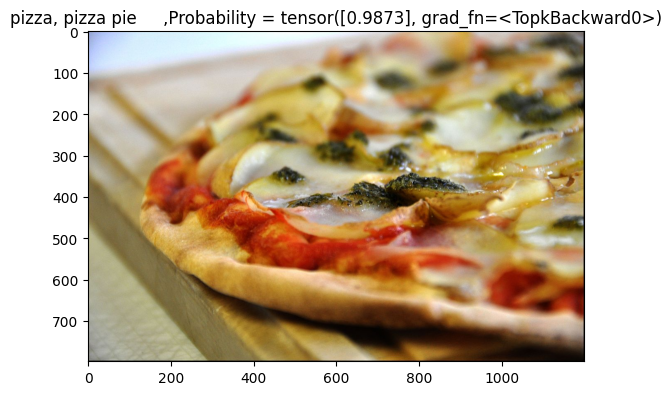

In [3]:
'''
Step - 1 : Download the pretrained Alexnet
'''

alexnet = models.alexnet(weights = models.AlexNet_Weights.DEFAULT)


'''
Optional - Print out the structure of Alexnet
'''

# print(alexnet)


'''
Step - 2 : Always a good practice to preprocess the images(s)
'''

preprocessFn = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])

'''
Step - 3 : Instantiate Alexnet in Eval Mode
'''

alexnet.eval()

'''
Step - 4 : Load a Test Image and Preprocess 
'''
path = "./Test-Images/pizza.jpg"
image = Image.open(path).convert('RGB')
inputVar =  Variable(preprocessFn(image).unsqueeze(0))


'''
Step - 5 : Run the Image through Alexnet
'''
predictions = alexnet(inputVar)
print(predictions.shape)

'''
Step - 6 : Output the Top Probability
'''
probs = F.softmax(predictions[0], dim = 0).topk(1)


'''
Step - 7 : Out the Image with Label and Probability
'''

plt.title(labels[predictions.argmax().item()] + '     ,Probability = ' + str(probs[0]))
plt.imshow(image);


torch.Size([55, 55])


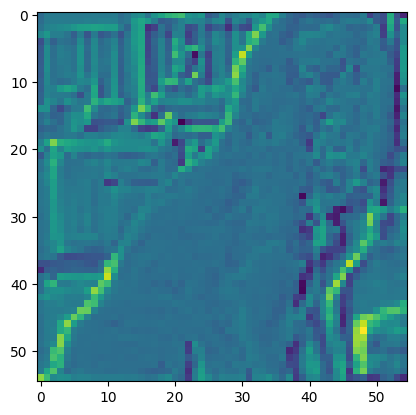

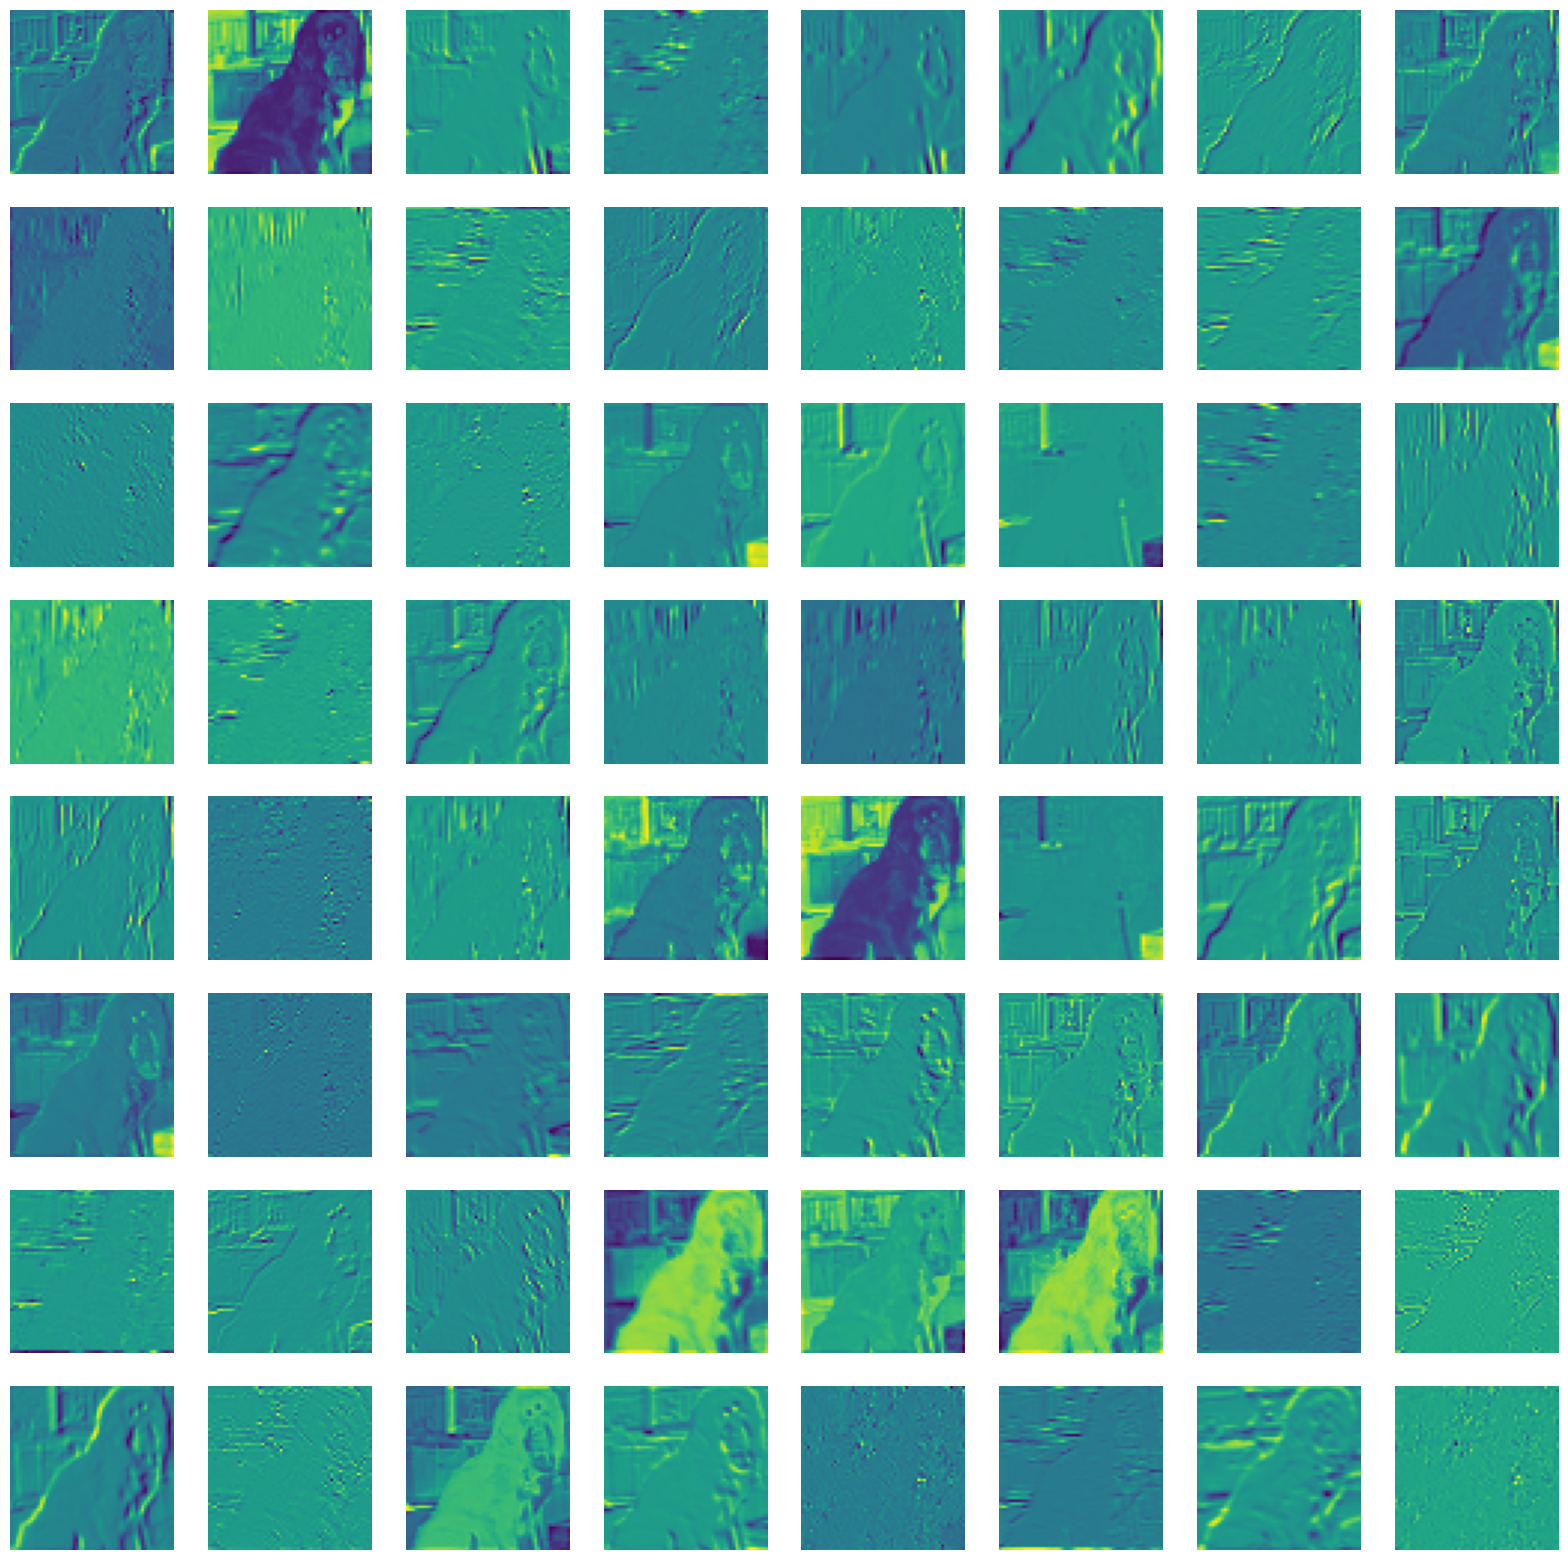

In [4]:
#Code to extract 1st Layer from Alexnet and Display shape

'''
Import the image and preprocess
'''

path = "Test-Images/dog.png"
image_c = Image.open(path).convert('RGB')
iVar =  Variable(preprocessFn(image_c).unsqueeze(0))

transformation = transforms.RandomInvert(1)
iVar = transformation(iVar)

'''
Extract the first Convolutional Layer
'''
feature_extraction = [child for child in alexnet.children()][0]
convolution_layer = feature_extraction[0]

'''
Run the image through this convolutional layer. Print out the shape and also the image representation.
'''
out = convolution_layer.forward(iVar)
print(out[0][0].shape)

'''
Note - The first Convolutional Layer extracts the outlines of the figure.
'''
plt.imshow(out[0][0].detach().numpy())

'''
*********
Write the code that outputs a grid (8x8) of the 64 images you get as the output of the first convolutional layer
*******
'''



plt.subplots(8,8,figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(out[0][i].detach().numpy())
    plt.axis('off')

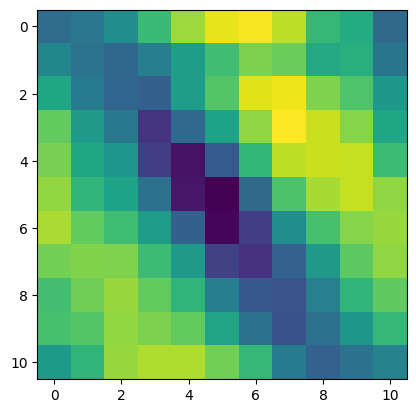

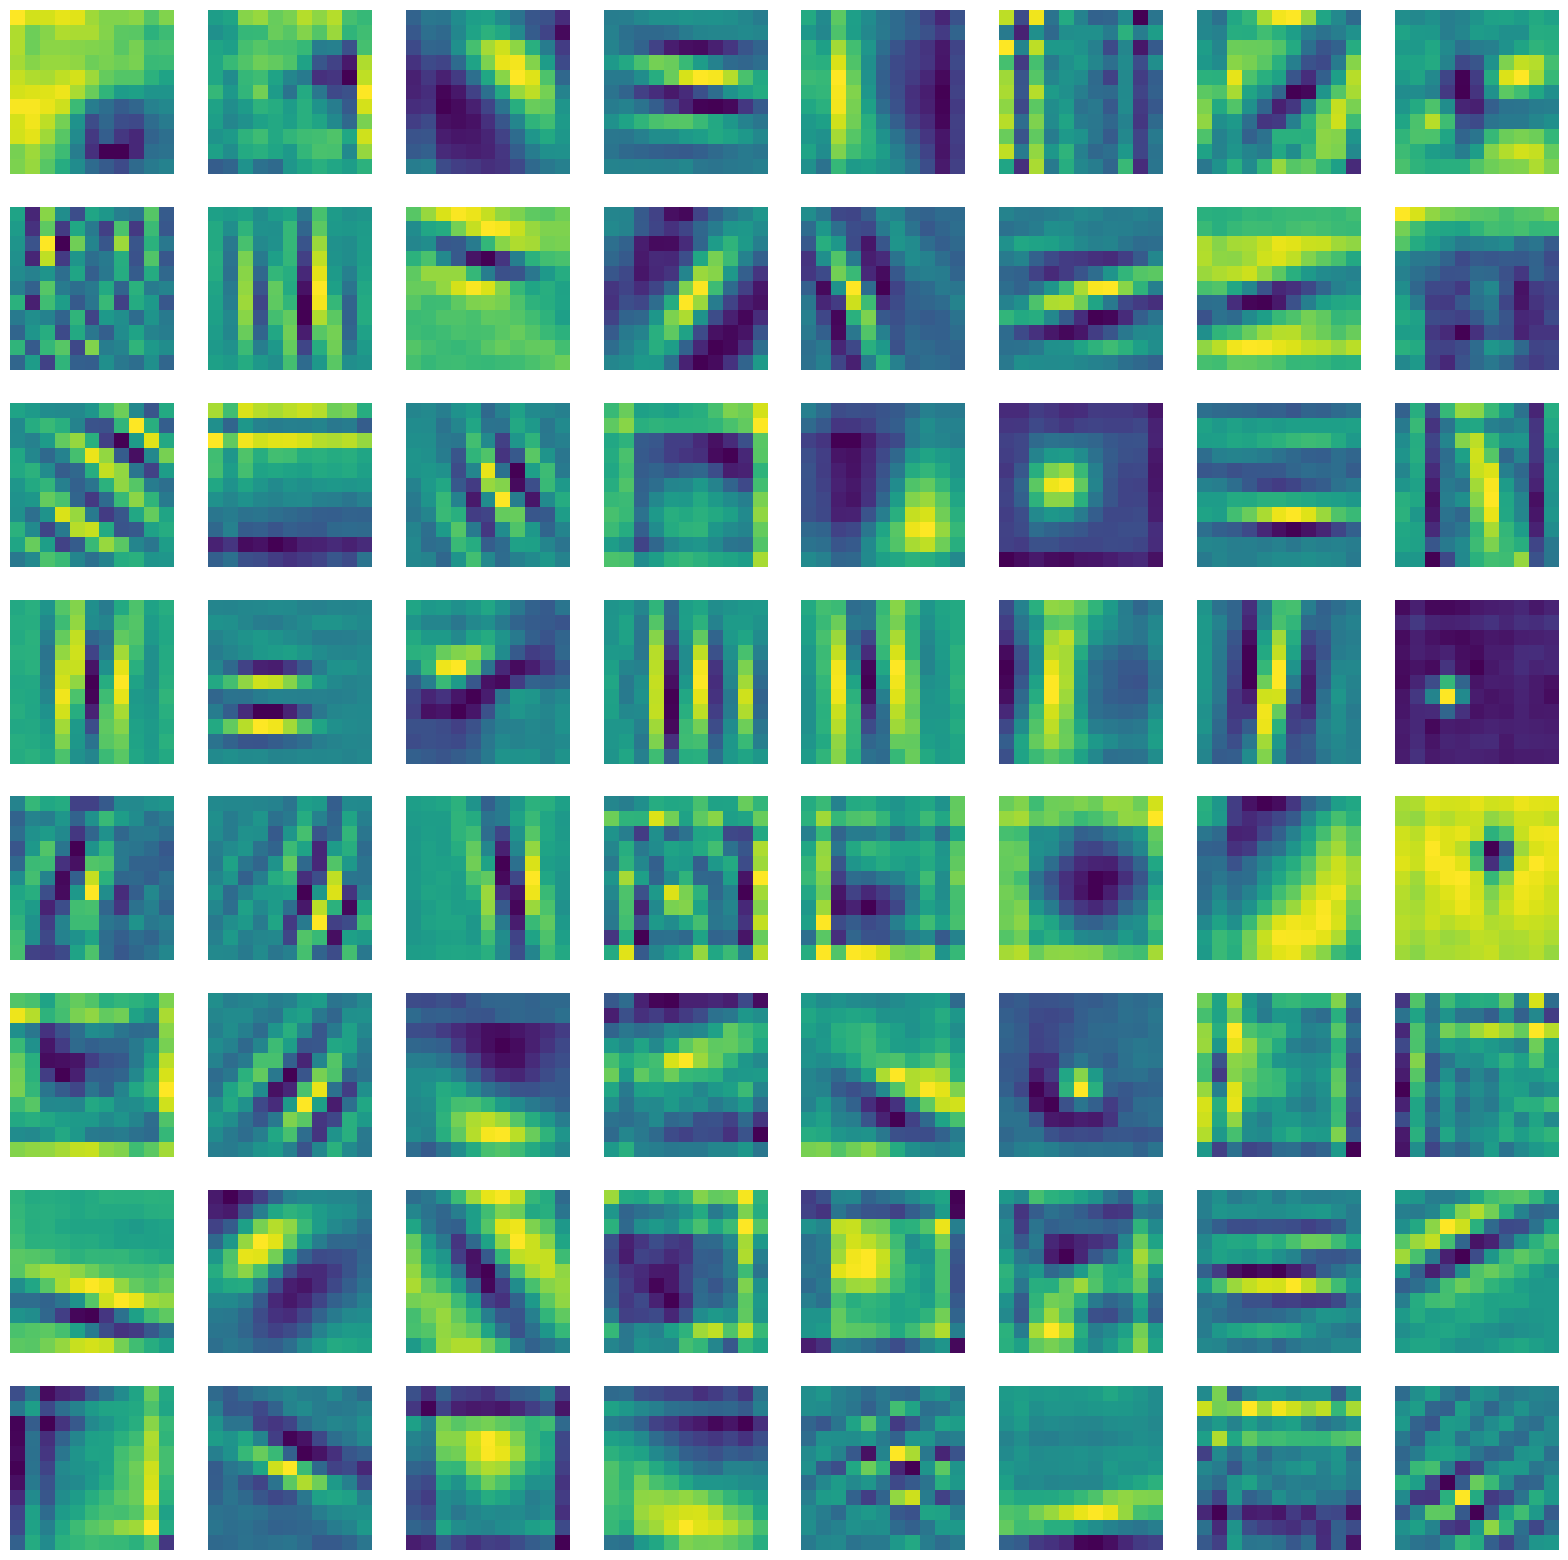

In [5]:
'''Now visualize the filters
* Look how I am extracting the weights of the 51th filter of the first channel 
and just extend it to create a grid plot of the 64 filters 
'''

plt.imshow(alexnet.features[0].weight.data[50,0,:,:])

plt.subplots(8,8,figsize=(20,20))
for i in range(64):
    image = alexnet.features[0].weight.data[i,0,:,:]
    plt.subplot(8,8,i+1)
    plt.imshow(image)
    plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['chain', 'pretzel', 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour', 'nematode, nematode worm, roundworm', 'brain coral']


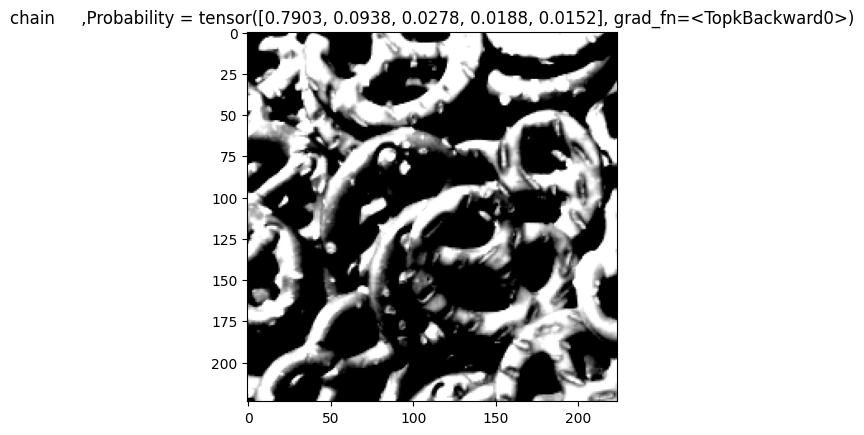

In [6]:
'''Here you will feed to the network your own image. And output the top 5 probabilities of the predicted classes.
* Make sure you make some preprocessing to it, you can also try blurring the image and see what happens
* Make sure your image class corresponds to one of the 1000 classes of alexnet
'''




path = "./Test-Images/pretzel3.png"
image = Image.open(path).convert('RGB')
inputVar =  Variable(preprocessFn(image).unsqueeze(0))

transform = transforms.Grayscale(3)
inputVar = transform(inputVar)

predictions = alexnet(inputVar)
probs = F.softmax(predictions[0], dim = 0).topk(5)


top_5_labels = [labels[i] for i in probs[1]]

print(top_5_labels)

# imshow transformed image
plt.title(labels[predictions.argmax().item()] + '     ,Probability = ' + str(probs[0]))
plt.imshow(inputVar[0].permute(1,2,0).detach().numpy());
